## Pump it Up: Data Mining the Water Table

Can you predict which water pumps are faulty?

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

Here is the work flow:
1. Data manipulation and visualization
2. Transform data for prediction
3. Build a model for prediction
4. Predict on test data then extract to csv file for result submission

### 1. Data manipulation and visualization

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)
plt.style.use('ggplot')

In [2]:
#read data from csv file
train_df = pd.read_csv('4910797b-ee55-40a7-8668-10efd5c1b960.csv', parse_dates=['date_recorded'])
test_df = pd.read_csv('702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')
train_label_df = pd.read_csv('0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
test_label_df = pd.read_csv('SubmissionFormat.csv')

In [3]:
#print first 5 rows
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
print(train_df['date_recorded'].min(), train_df['date_recorded'].max())

2002-10-14 00:00:00 2013-12-03 00:00:00


Data is recorded between Oct 14, 2002 and Dec 3, 2013.

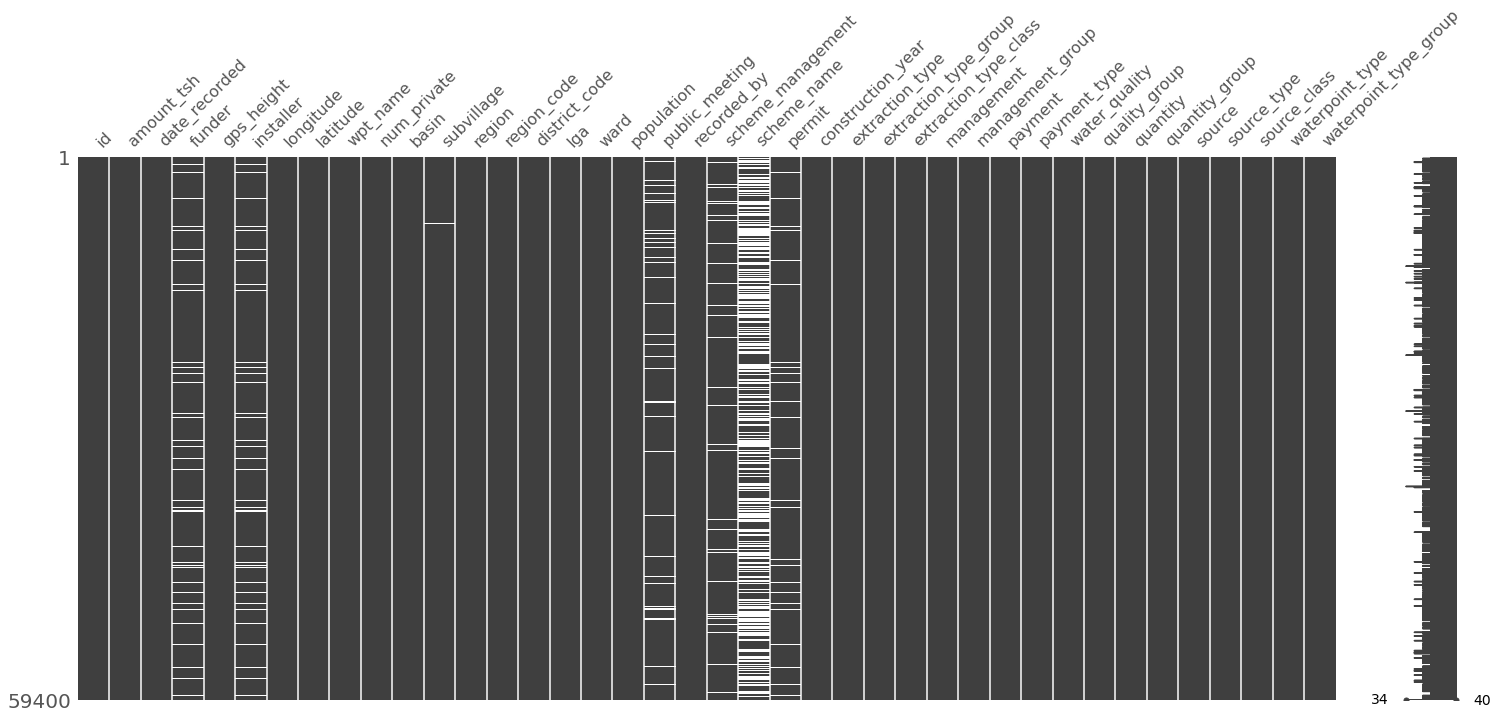

In [5]:
#matrix of null values
msno.matrix(train_df)

Column 'funder' and 'installer' have missing values in same rows.

In [6]:
#percentage of null values in columns has null values
pct_missing = train_df.isnull().mean()*100
pct_missing[pct_missing > 0]

funder                6.119529
installer             6.153199
subvillage            0.624579
public_meeting        5.612795
scheme_management     6.526936
scheme_name          47.417508
permit                5.144781
dtype: float64

<font color='blue'>Column scheme_name has the highest missing value at 47.42% => Drop this colum.</font>

In [7]:
#drop column 'scheme_name'
train_df.drop('scheme_name', axis=1, inplace=True)

In [8]:
#number of null values in columns has null values
num_missing = train_df.isnull().sum()
num_missing[num_missing > 0]

funder               3635
installer            3655
subvillage            371
public_meeting       3334
scheme_management    3877
permit               3056
dtype: int64

In [9]:
#type of columns has missing values
missing_index = num_missing[num_missing > 0].index
for i in missing_index:
    print(train_df[i].dtype)

object
object
object
object
object
object


<font color='blue'>Columns have missing values are in type "Object". I'm going to fill missing value by "Unknown"</font>

In [10]:
#fill na value by 'Unknown'
train_df.fillna('Unknown', inplace=True)

In [11]:
#print number of unique value in each column
train_columns = train_df.columns
for col in train_columns:
    if train_df[col].dtype == 'O':
        print (f'Column name: {col}')
        print(train_df[col].value_counts())
        print('===============')

Column name: funder
Government Of Tanzania    9084
Unknown                   3639
Danida                    3114
Hesawa                    2202
Rwssp                     1374
                          ... 
Ndm                          1
Tlc/community                1
Opec                         1
R                            1
Mtambo                       1
Name: funder, Length: 1897, dtype: int64
Column name: installer
DWE                17402
Unknown             3658
Government          1825
RWE                 1206
Commu               1060
                   ...  
Mpango wa Mwisa        1
KUMKUM                 1
Mr Luo                 1
COYI                   1
Athumani Issa          1
Name: installer, Length: 2145, dtype: int64
Column name: wpt_name
none             3563
Shuleni          1748
Zahanati          830
Msikitini         535
Kanisani          323
                 ... 
Kwa Nyanganyi       1
Endamaghay          1
Kwa Meene           1
Kwa Marika          1
Rc Kanisani   

<font color='blue'>There are 1,897 funders. Check number of pumps contribution by number of funders.</font>

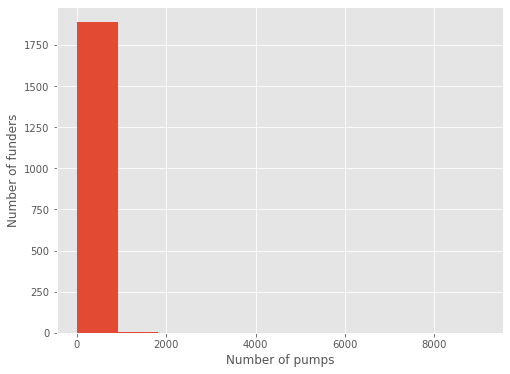

In [12]:
#plot histogram number of pumps contribution with number of funders
funder_count = train_df['funder'].value_counts()
plt.hist(funder_count, bins=10)
plt.xlabel('Number of pumps')
plt.ylabel('Number of funders')
plt.show()

In [13]:
funder_less_10 = funder_count[funder_count<10].index
funder_less_10

Index(['Williamson Diamond Ltd', 'Aimgold', 'Holla', 'Kadres Ngo',
       'People Of Japan', 'Kingupira S', 'W.D & I.', 'Hortanzia', 'Mem',
       'Healt',
       ...
       'St Elizabeth Majengo', 'Wdsp', 'Kwasenenge Group', 'Vwcvwc', 'Brad',
       'Ndm', 'Tlc/community', 'Opec', 'R', 'Mtambo'],
      dtype='object', length=1490)

<font color='blue'>There are 2,145 installers. Check number of pumps by number of installer.</font>

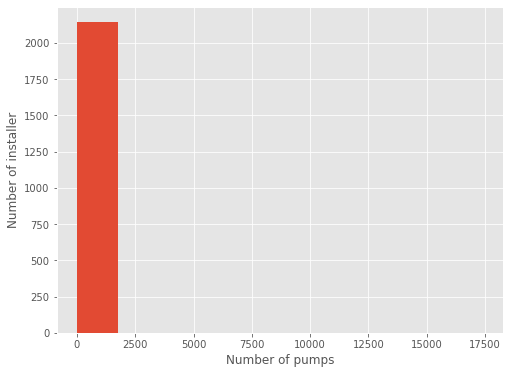

In [14]:
installer_count = train_df['installer'].value_counts()
plt.hist(installer_count)
plt.xlabel('Number of pumps')
plt.ylabel('Number of installer')
plt.show()

In [15]:
installer_less_10 = installer_count[installer_count<10].index
installer_less_10

Index(['AIMGOLD', 'Kalago enterprises Co.Ltd', 'MISSION', 'RUDEP',
       'REGIONAL WATER ENGINEER ARUSHA', 'GERMANY MISSIONARY', 'Mzinga A',
       'CCT', 'Singida General  Supplies  Ltd', 'No',
       ...
       'UMOJA DRILLING CONTRACTOR', 'Jiks', 'Claver',
       'sengerema water Department', 'Usambala sisters', 'Mpango wa Mwisa',
       'KUMKUM', 'Mr Luo', 'COYI', 'Athumani Issa'],
      dtype='object', length=1721)

In [16]:
train_df['funder_less_10'] = [1 if i in funder_less_10 else 0 for i in train_df['funder']]
train_df['installer_less_10'] = [1 if i in installer_less_10 else 0 for i in train_df['installer']]

Drop columns:
- date_recorded: It is not needed for analysis
- recorded by: All data are recorded by "GeoData Consultants Ltd"
- wpt_name (37400 unique values), subvillage(19288 unique values): There are various of unique values while number of data rows is 59,400. Therefore I won't keep these columns for analysis.
- funder, installer: replaced by 'funder_less_10','installer_less_10'
- ward: There are 2,092 wards
- region: I got 'region_code' so I don't need 'region'

In [17]:
train_df.drop(['date_recorded', 'recorded_by','wpt_name','subvillage','funder', 'installer','ward','region'], axis=1, inplace=True)

In [18]:
#function to get duplicated columns value in pairs
def get_duplicated_columns_in_pairs(df):
    cols = list(df.columns)
    duplicated_columns = []
    cols_copy = cols.copy()
    for i in cols:
        cols_copy.pop(0)
        for j in cols_copy:
            if(df[i].equals(df[j])):
                duplicated_columns.append((i,j))
    return duplicated_columns

<font color='blue'>Column 'payment' and 'payment_type' seems has the same value but their value are a little bit different. I'm going to change the value in 'payment' to make it has the same value in 'payment_type'. </font>

In [19]:
mapper = {'never pay': 'never pay', 'pay per bucket':'per bucket', 'pay monthly': 'monthly', 'unknown':'unknown', 'pay when scheme fails':'on failure', 'pay annually':'annually','other':'other'}
train_df['payment'] = train_df['payment'].map(mapper)
train_df['payment'].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment, dtype: int64

In [20]:
#check duplicated columns
duplicated_cols = get_duplicated_columns_in_pairs(train_df)
duplicated_cols

[('payment', 'payment_type'), ('quantity', 'quantity_group')]

In [21]:
#delete duplicated columns, keep 'payment' and 'quantity'
for pair in duplicated_cols:
    del train_df[pair[1]]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   gps_height             59400 non-null  int64  
 3   longitude              59400 non-null  float64
 4   latitude               59400 non-null  float64
 5   num_private            59400 non-null  int64  
 6   basin                  59400 non-null  object 
 7   region_code            59400 non-null  int64  
 8   district_code          59400 non-null  int64  
 9   lga                    59400 non-null  object 
 10  population             59400 non-null  int64  
 11  public_meeting         59400 non-null  object 
 12  scheme_management      59400 non-null  object 
 13  permit                 59400 non-null  object 
 14  construction_year      59400 non-null  int64  
 15  ex

In [22]:
#check duplicated rows
train_df[train_df.duplicated()]

,id,amount_tsh,gps_height,longitude,latitude,num_private,basin,region_code,district_code,lga,...,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,funder_less_10,installer_less_10


In [23]:
#shape of final train_df
train_df.shape

(59400, 31)

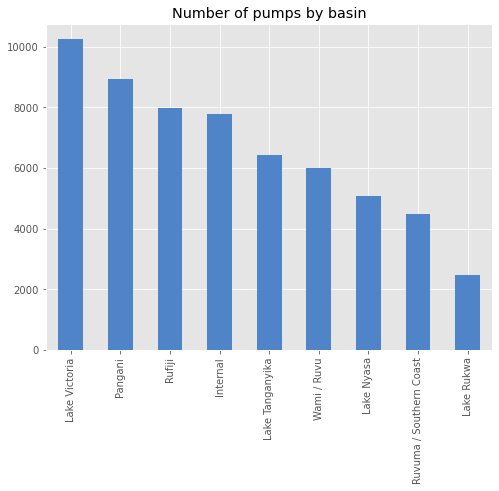

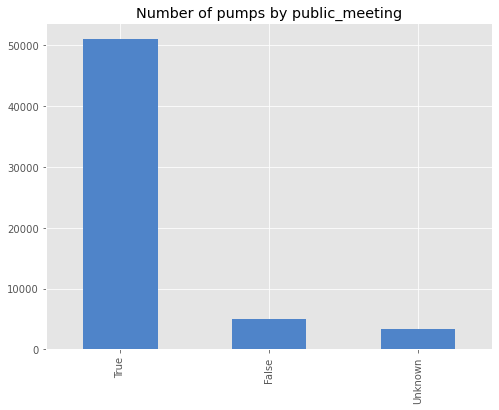

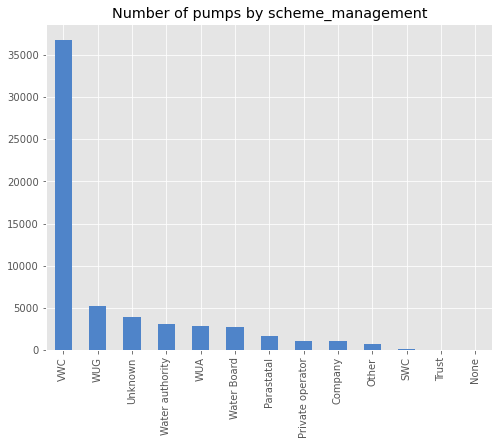

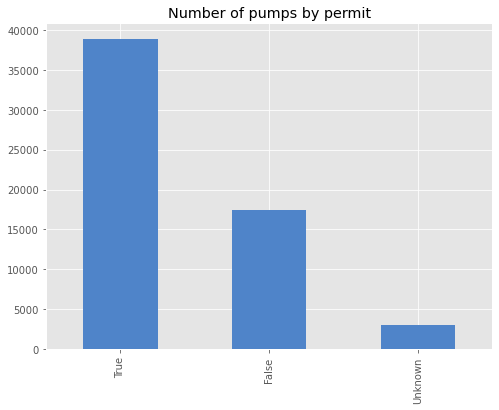

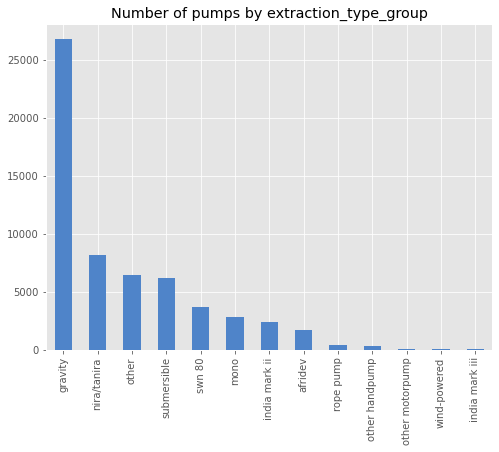

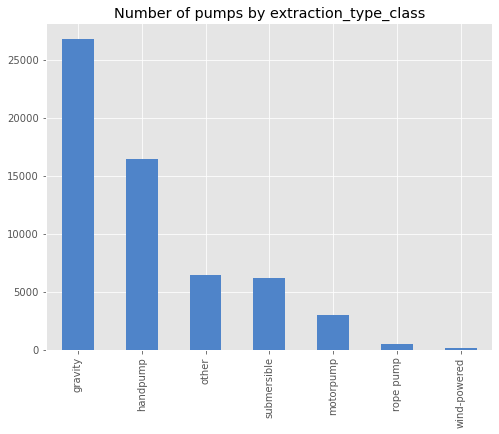

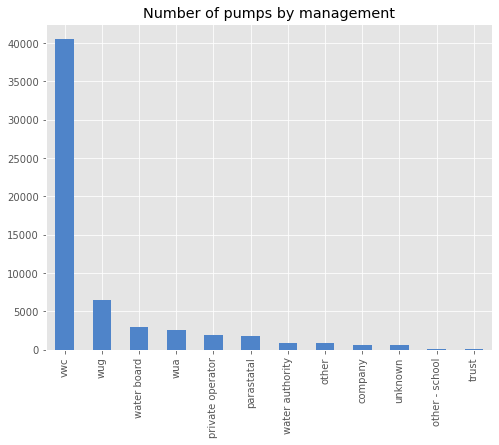

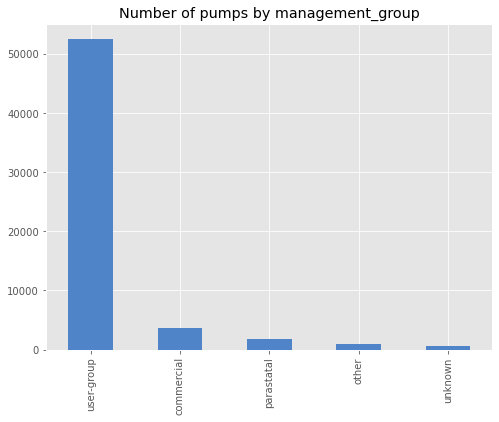

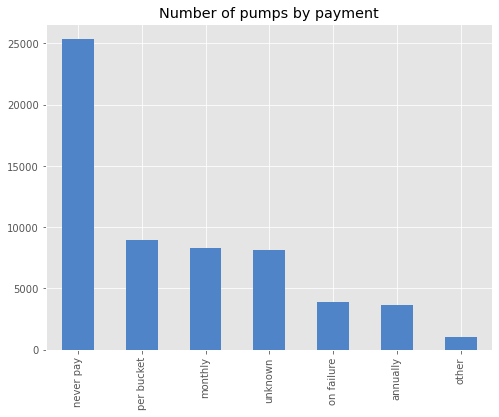

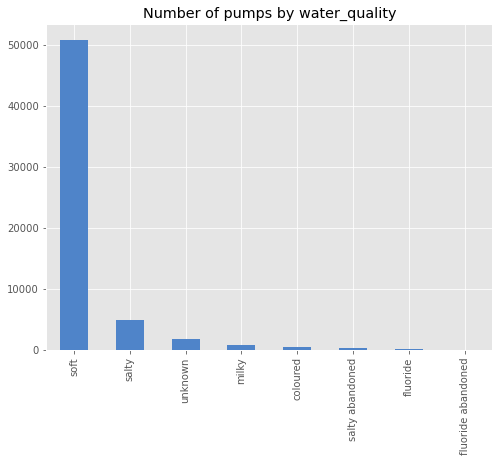

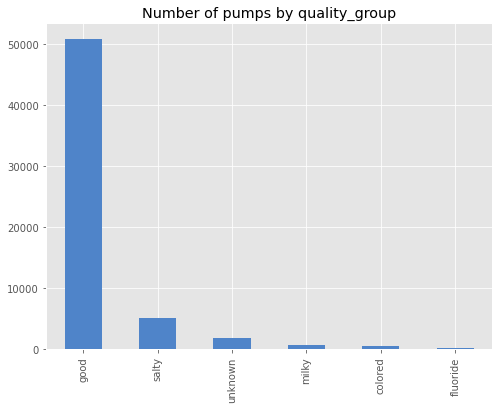

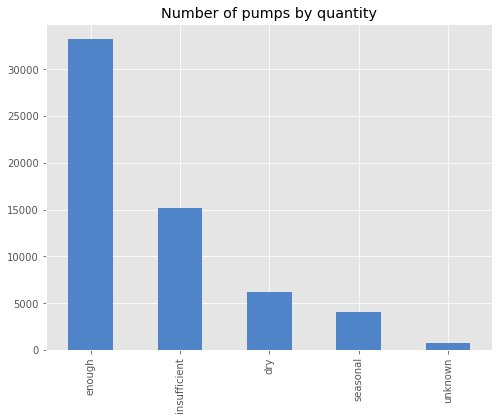

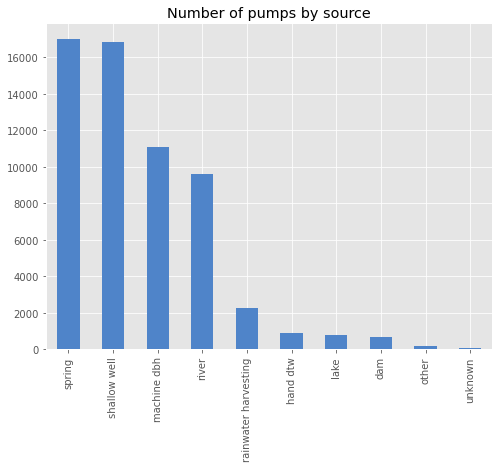

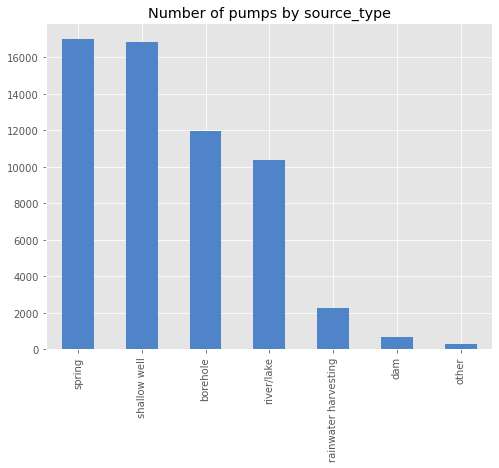

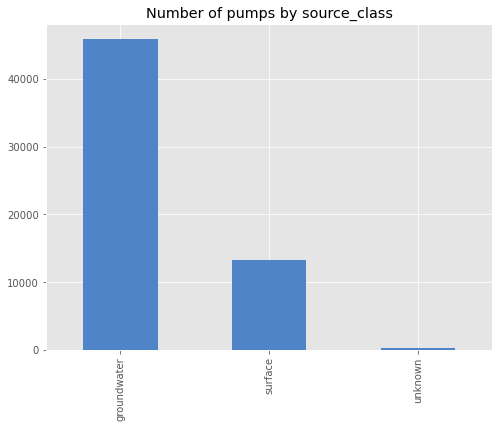

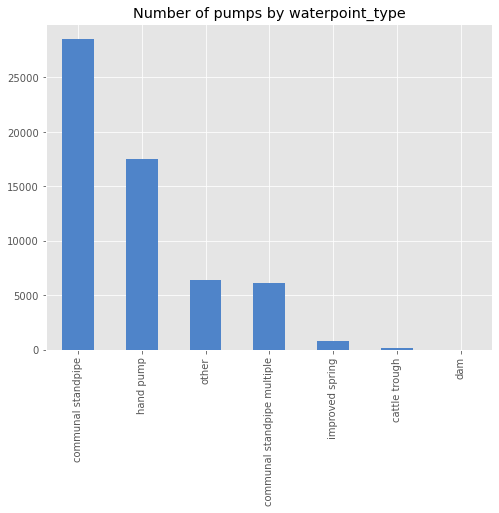

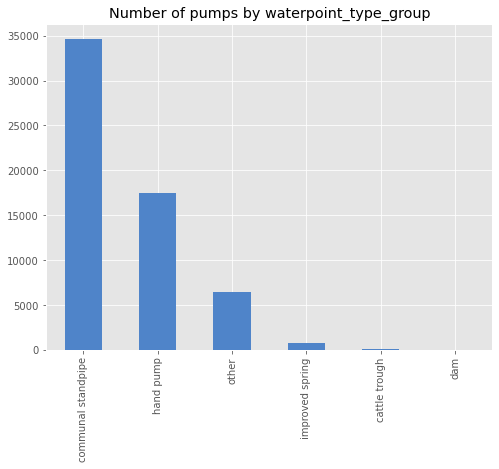

In [24]:
#plot number of pumps by column has type 'Object' and only display columns have number of unique value less than 15
train_cols = train_df.columns
for col in train_cols:
    val_count = train_df[col].value_counts()
    if (train_df[col].dtypes == 'O') and (val_count.count() < 15):
        val_count.plot(kind='bar', color='#4f84c9')
        plt.title(f'Number of pumps by {col}')
        plt.show()

### Finding from the plots:
- VWC manages almost pumps
- Gravity is the most popular in extraction type group

### Train labels

In [25]:
train_label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [26]:
#count number of each label
train_label_df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

#### Merge train data with label

In [27]:
#merge label to train_df on id
train_df = pd.merge(left=train_df, right=train_label_df, on='id', how='left')

In [28]:
train_df.columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'basin', 'region_code', 'district_code', 'lga',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'water_quality', 'quality_group', 'quantity', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'funder_less_10', 'installer_less_10', 'status_group'],
      dtype='object')

In [29]:
train_df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,funder_less_10,installer_less_10
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,0.050455,0.059428
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,0.218883,0.236425
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,0.000000,0.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,0.000000,0.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,1.000000,1.000000


In [30]:
#function to plot status group in each column
def plot_status(col_name):
    df = train_df[[col_name, 'status_group']]
    series_group_count = df.groupby([col_name, 'status_group'])['status_group'].count()
    df_group_count = series_group_count.to_frame().add_suffix('_count')
    df_group_count = df_group_count.reset_index().sort_values(by=[col_name, 'status_group_count'])
    sns.barplot(x=f'{col_name}', y='status_group_count', data=df_group_count, hue='status_group')\
        .set_title(f'Number of pumps by {col_name}')
    plt.xticks(rotation=30, horizontalalignment="center")
    plt.show()

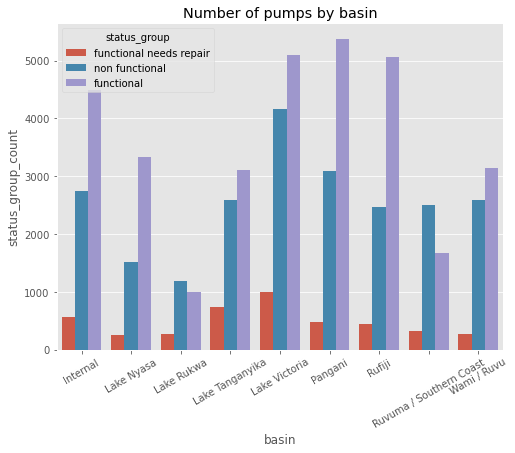

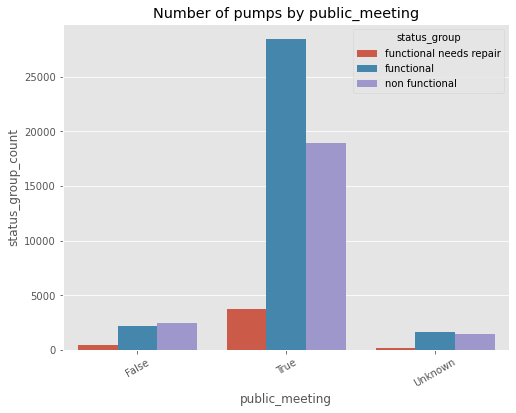

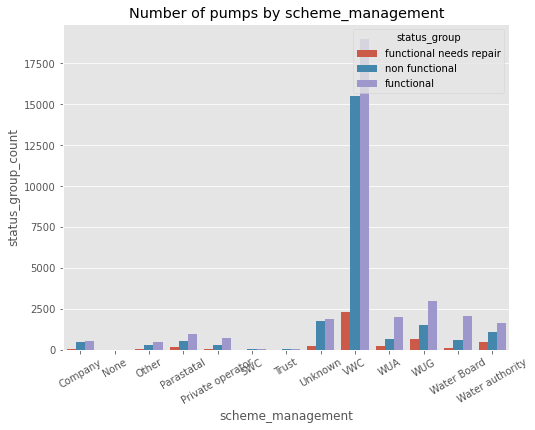

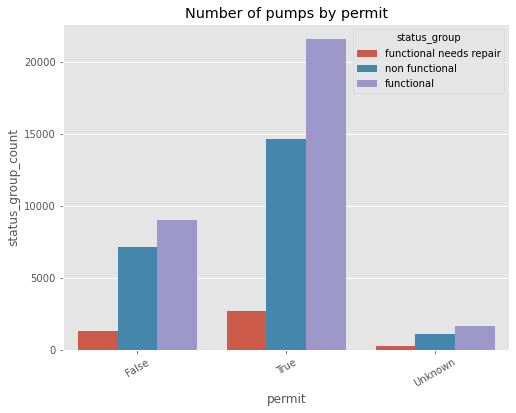

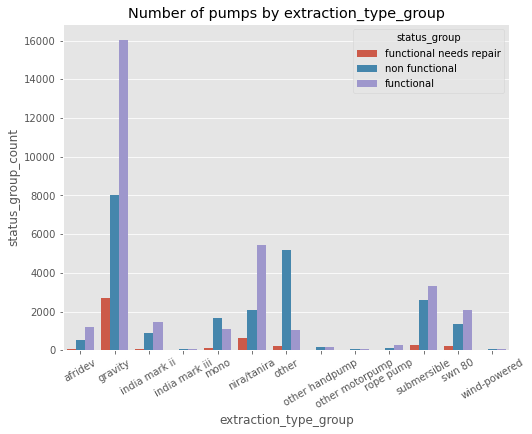

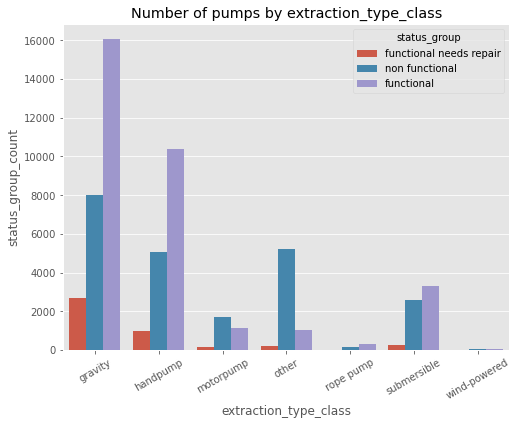

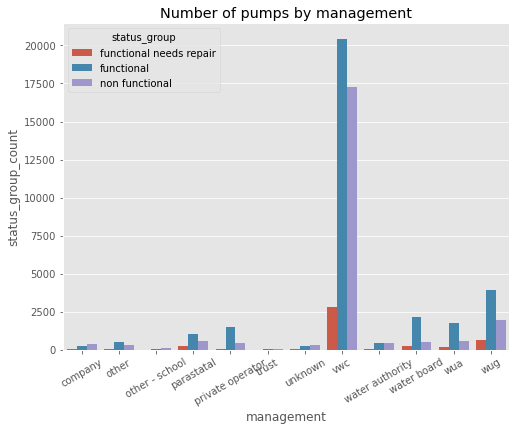

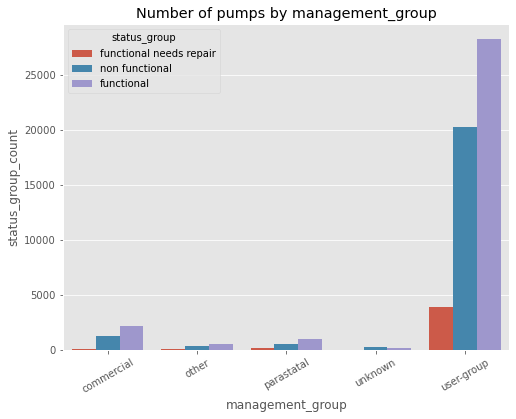

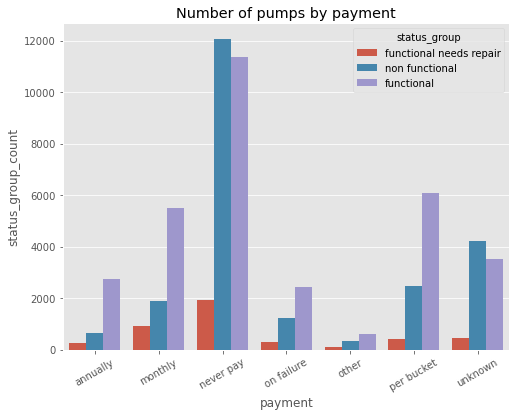

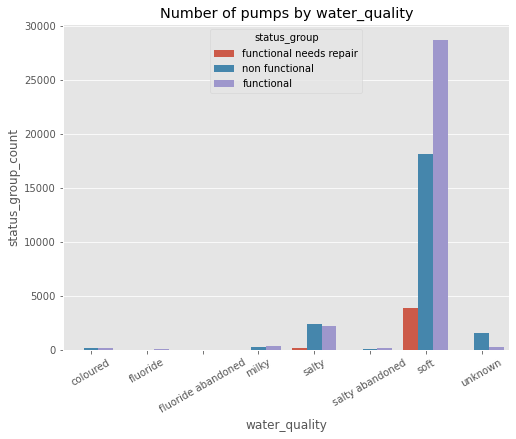

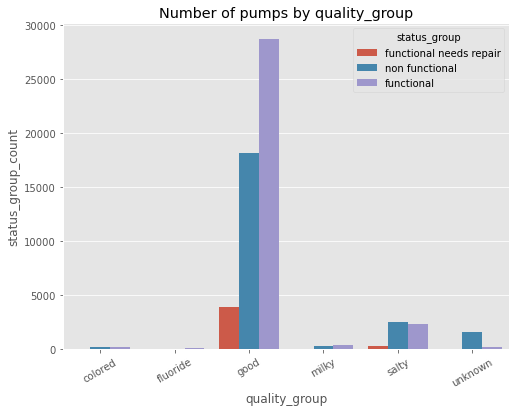

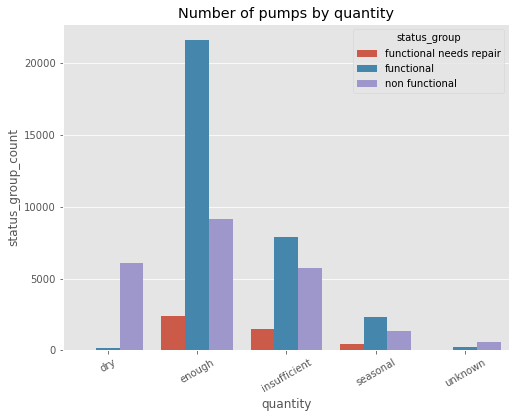

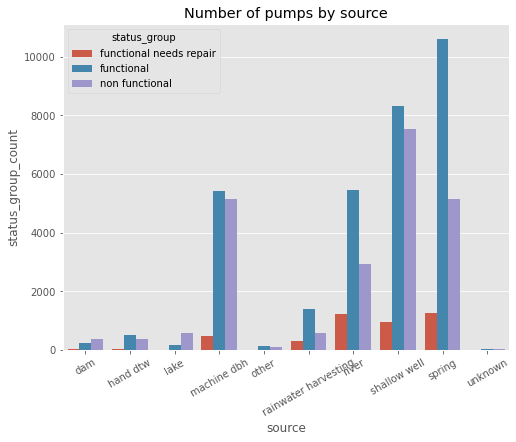

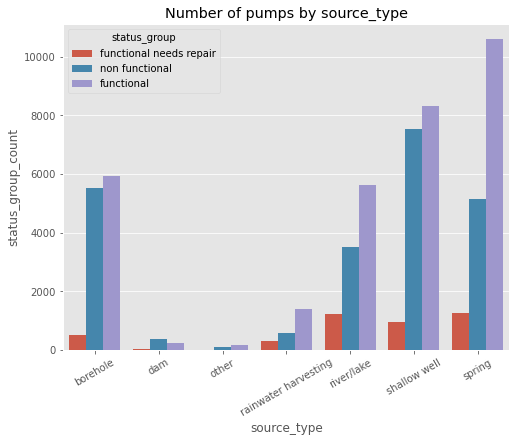

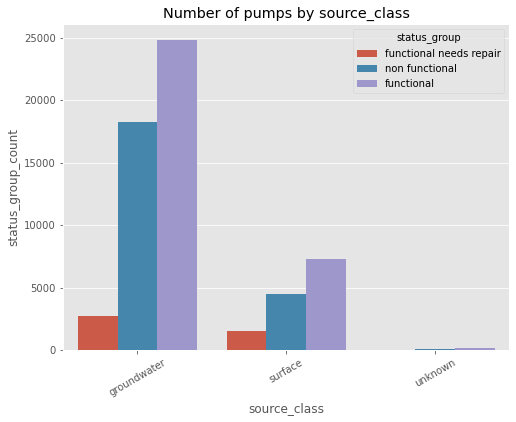

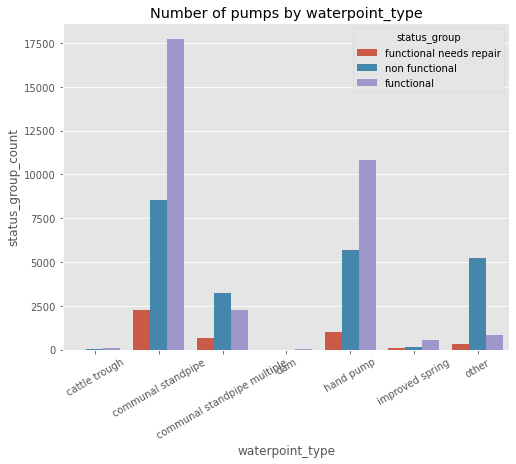

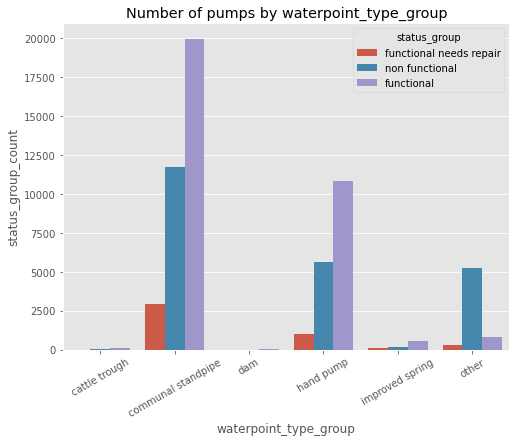

In [31]:
train_cols = train_df.drop('status_group', axis=1).columns

for col in train_cols:
    if train_df[col].dtype == 'O' and train_df[col].value_counts().count() < 15:
        plot_status(col)

In [32]:
#convert column 'status_group' to numeric
mapper = {'non functional': 0, 'functional': 1, 'functional needs repair': 2}
train_df['status_group'] = train_df['status_group'].map(mapper)

In [33]:
#number of each data type
train_df.dtypes.value_counts()

object     19
int64      10
float64     3
dtype: int64

In [34]:
train_df.columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'basin', 'region_code', 'district_code', 'lga',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'water_quality', 'quality_group', 'quantity', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'funder_less_10', 'installer_less_10', 'status_group'],
      dtype='object')

In [35]:
mapper = {True: 1, False: 0, 'Unknown': 2}
train_df['public_meeting'] = train_df['public_meeting'].map(mapper)
train_df['permit'] = train_df['permit'].map(mapper)

In [36]:
# train_df_copy = train_df.copy()

### 2. Transform data for prediction

In [37]:
ohe_dict = {}
df_list = []
cols = train_df.columns
for col in cols:
    if train_df[col].dtype == 'O':
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        reshape_data = train_df[col].values.reshape(-1,1)
        ohe.fit(reshape_data)
        result = ohe.transform(reshape_data)
        df = pd.DataFrame(result,columns = [f'{col}_'+i for i in ohe.categories_])
        ohe_dict[col] = ohe
        df_list.append(df)
        del train_df[col]

In [38]:
df_list.append(train_df)
df = pd.concat(df_list, axis=1)
df.shape

(59400, 276)

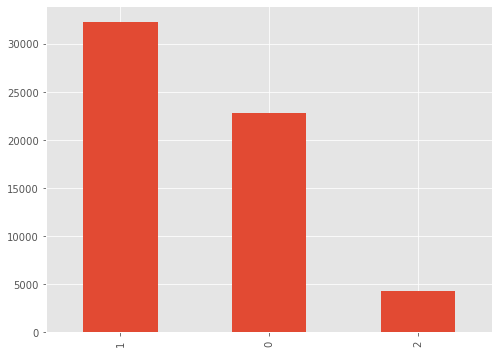

In [39]:
#plt number of status_group
count_status = df['status_group'].value_counts()
count_status.plot(kind='bar')
plt.show()

<font color='blue'>There are imbalanced classes. I'm going to upsample class 0 and 2.</font>

In [40]:
X = df.drop(['id','status_group'], axis=1)
y = df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=1)

X_upsampled_0, y_upsampled_0 = resample(X_train[y_train==0],
                                    y_train[y_train==0],
                                    replace=True, 
                                    n_samples = X_train[y_train==1].shape[0],
                                    random_state=1)
X_upsampled_2, y_upsampled_2 = resample(X_train[y_train==2],
                                       y_train[y_train==2],
                                       replace=True,
                                       n_samples = X_train[y_train ==1].shape[0],
                                       random_state=1)


X_train_bal = np.vstack((X_train[y_train == 1], X_upsampled_0, X_upsampled_2))
y_train_bal = np.hstack((y_train[y_train ==1], y_upsampled_0, y_upsampled_2))

In [41]:
print(X_train_bal.shape, y_train_bal.shape)

(67743, 274) (67743,)


In [42]:
#count number of classes after upsampling
from collections import Counter
Counter(y_train_bal)

Counter({1: 22581, 0: 22581, 2: 22581})

In [43]:
# from lazypredict.Supervised import LazyClassifier
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# models,prediction = clf.fit(X_train_bal, X_test, y_train_bal, y_test)
# models

### 3. Build a model for prediction

In [44]:
steps = [('scaler', StandardScaler()),
        ('pca', PCA()),
        ('forest_model', RandomForestClassifier(random_state=1))]
pipe = Pipeline(steps)
pipe.fit(X_train_bal, y_train_bal)
print(f'Train score: {pipe.score(X_train_bal, y_train_bal)}')
print(f'Test score: {pipe.score(X_test, y_test)}')

Train score: 0.9953205497246947
Test score: 0.7707070707070707


In [45]:
y_pred = pipe.predict(X_test)
status = ['non functional','functional','functional needs repair']
true_status = ['true '+ i for i in status]
predict_status = ['predict '+ i for i in status]

pd.DataFrame(data=confusion_matrix(y_test,y_pred), index=true_status, columns=predict_status)

,predict non functional,predict functional,predict functional needs repair
true non functional,5095,1533,219
true functional,1014,8072,592
true functional needs repair,191,537,567


In [46]:
# param_grid = {'pca__n_components': np.arange(100,201,20),
#                 'forest_model__n_estimators': np.arange(60,91,10), 
# #               'forest_model__criterion': ['gini', 'entropy'],
#              'forest_model__min_samples_leaf': np.arange(0.1, 0.31, 0.05)}
# steps = [('scaler', StandardScaler()),
#         ('pca', PCA()),
#         ('forest_model', RandomForestClassifier(random_state=1))]
# pipe = Pipeline(steps)

# pipe_cv = RandomizedSearchCV(pipe, param_grid, cv=5)
# pipe_cv.fit(X_train_bal, y_train_bal)
# pipe_cv.best_params_

In [47]:
#build model on best params
# steps = [('scaler', StandardScaler()),
#         ('pca', PCA(n_components=120)),
#         ('forest_model', RandomForestClassifier(n_estimators=60, min_samples_leaf =0.1, random_state=1))]
# best_pipe = Pipeline(steps)
# best_pipe.fit(X_train_bal, y_train_bal)
# print(f'Train score: {best_pipe.score(X_train_bal, y_train_bal)}')
# print(f'Test score: {best_pipe.score(X_test, y_test)}')

### 4. Predict on test data then extract to csv file for submission

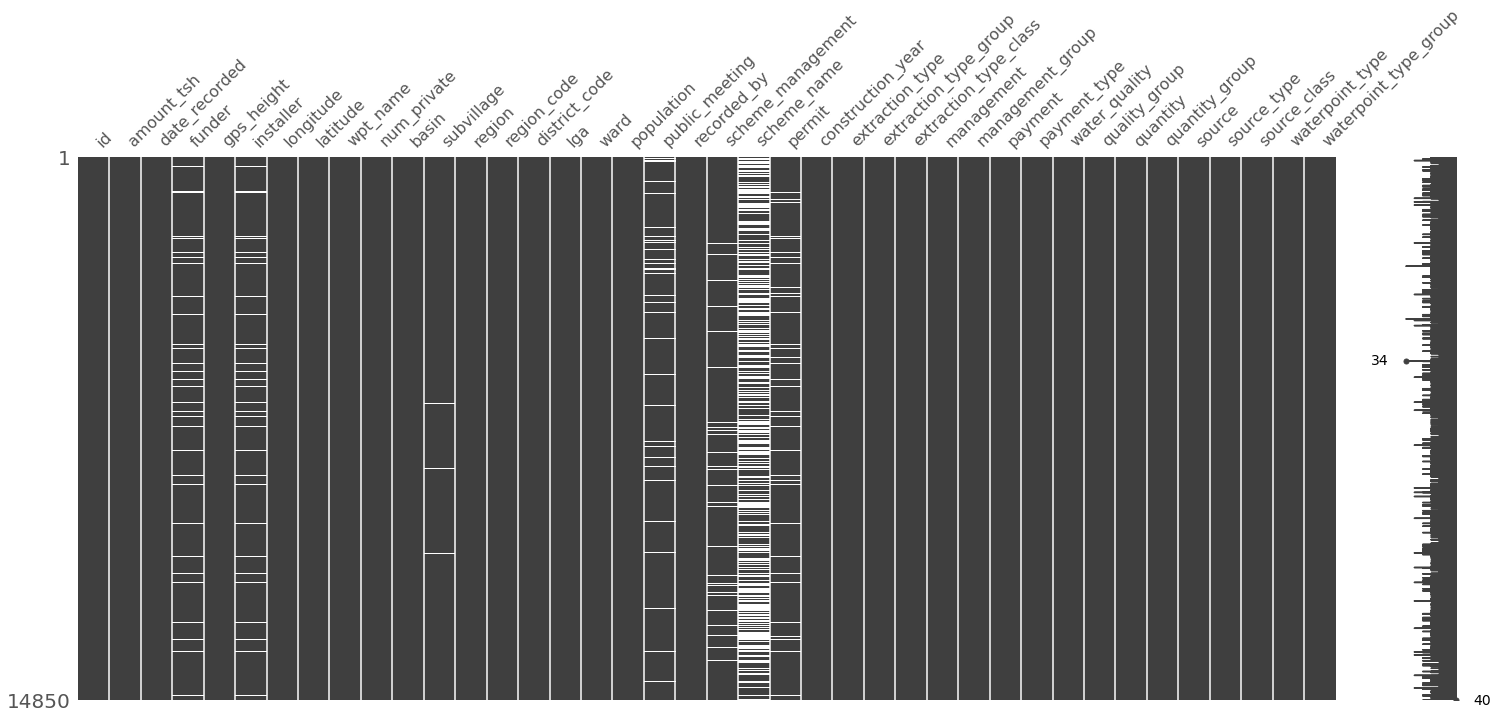

In [48]:
#matrix of missing value
msno.matrix(test_df)

In [49]:
#percentage of null values in each column
test_df.isnull().mean()

id                       0.000000
amount_tsh               0.000000
date_recorded            0.000000
funder                   0.058519
gps_height               0.000000
installer                0.059057
longitude                0.000000
latitude                 0.000000
wpt_name                 0.000000
num_private              0.000000
basin                    0.000000
subvillage               0.006667
region                   0.000000
region_code              0.000000
district_code            0.000000
lga                      0.000000
ward                     0.000000
population               0.000000
public_meeting           0.055286
recorded_by              0.000000
scheme_management        0.065253
scheme_name              0.477576
permit                   0.049630
construction_year        0.000000
extraction_type          0.000000
extraction_type_group    0.000000
extraction_type_class    0.000000
management               0.000000
management_group         0.000000
payment       

In [50]:
#fill na value by 'Unknown'
test_df.fillna('Unknown', inplace=True)

In [51]:
test_df['funder_less_10'] = [1 if i in funder_less_10 else 0 for i in test_df['funder']]
test_df['installer_less_10'] = [1 if i in installer_less_10 else 0 for i in test_df['installer']]

mapper = {True: 1, False: 0, 'Unknown': 2}
test_df['public_meeting'] = test_df['public_meeting'].map(mapper)
test_df['permit'] = test_df['permit'].map(mapper)

In [52]:
drop_columns = ['date_recorded','scheme_name','recorded_by','wpt_name','subvillage',\
                'funder', 'installer','ward','payment_type', 'quantity_group','region']
test_df.drop(drop_columns, axis=1, inplace=True)

In [53]:
test_df_copy = test_df.copy()

In [54]:
df_list = []
cols = test_df.columns
for col in cols:
    if test_df[col].dtype == 'O':
        reshape_data = test_df[col].values.reshape(-1,1)
        result = ohe_dict[col].transform(reshape_data)
        df = pd.DataFrame(result,columns = [f'{col}_'+i for i in ohe_dict[col].categories_])
        df_list.append(df)
        del test_df[col]

In [55]:
df_list.append(test_df)
tdf = pd.concat(df_list, axis=1)
tdf.shape

(14850, 275)

In [56]:
X_test = tdf.drop('id', axis=1)
y_pred = pipe.predict(X_test)

In [57]:
test_dict = {'id':tdf['id'],'status_group': y_pred}
result_df = pd.DataFrame(test_dict)
result_df.head()

,id,status_group
0,50785,1
1,51630,1
2,17168,1
3,45559,0
4,49871,1


In [58]:
mapper = {0:'non functional', 1:'functional', 2:'functional needs repair'}
result_df['status_group'] = result_df['status_group'].map(mapper)

In [59]:
test_label = pd.merge(left=test_label_df, right=result_df, on='id', how='left')
test_label.drop('status_group_x', axis=1, inplace=True)
test_label.rename(columns={'status_group_y':'status_group'}, inplace=True)
test_label.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [60]:
#export result to csv file then submission to drivedata.com
test_label.to_csv('result_submissions.csv', index=False)